In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# copy is a version where I cleaned up several really key term parsing issues
data_dir = '../data/textbooks_extracted_copy'

# DataSet Info

Pulls together statistics on term data.

In [20]:
df = {}
counts = {}
df['textbook'] = ['life_biology', 'open_stax_anatomy_physiology', 'open_stax_astronomy', 'open_stax_biology_2e', 
                  'open_stax_chemistry_2e', 'open_stax_microbiology', 'open_stax_university_physics_v3']
df['# sentences'] = []
df['# zero key terms'] = []
df['# non-zero key terms'] = []
df['data split'] = []
for textbook in df['textbook']:
    
    # key term counts
    with open('%s/%s_key_term_counts.json' % (data_dir, textbook), 'r') as f:
        counts[textbook] = json.load(f)
    
    df['# zero key terms'].append(len([term for term in counts[textbook] if counts[textbook][term] == 0]))
    df['# non-zero key terms'].append(len([term for term in counts[textbook] if counts[textbook][term] > 0]))
        
    # number of sentences
    with open('%s/%s_sentences.txt' % (data_dir, textbook), 'r') as f:
        df['# sentences'].append(len(f.readlines()))
        
    # number of definition sentences    
    #with open('%s/%s_sentences.txt' % (data_dir, textbook), 'r') as f:
    #    df['# sentences'].append(len(f.readlines()))
    
    # data split
    if textbook == 'life_biology':
        df['data split'].append('test')
    elif textbook == 'open_stax_biology_2e':
        df['data split'].append('dev')
    else:
        df['data split'].append('train')

df = pd.DataFrame(df)
df

,textbook,# sentences,# zero key terms,# non-zero key terms,data split
0,life_biology,28662,343,1957,test
1,open_stax_anatomy_physiology,17804,79,2948,train
2,open_stax_astronomy,13384,22,306,train
3,open_stax_biology_2e,20529,330,1966,dev
4,open_stax_chemistry_2e,8262,81,677,train
5,open_stax_microbiology,11509,176,1492,train
6,open_stax_university_physics_v3,5500,38,362,train


# Accumulate Info On Model Outputs

false_pos.txt, false_neg.txt, true_pos.txt are the BERT model outputs.

ner_fixed_data is the accumulated train and test data from the textbooks_extracted_copy data where some parsing errors were fixed.

We create a dataframe for each term from the above three files containing their model average probability, the term length, their counts in the training and test data, and an indicator for whether they were tagged as a key term in the training data.

In [221]:
from nltk import word_tokenize
from collections import Counter

# read in train + test sentences & key terms
with open('../data/ner_fixed_data/full/test/sentences.txt') as f:
    test_text = ' '.join(f.readlines()).lower()
with open('../data/ner_fixed_data/full/test/terms.txt') as f:
    test_kts = set([word.replace('\n', '') for word in f.readlines()])
with open('../data/ner_fixed_data/full/train/sentences.txt') as f:
    train_text = ' '.join(f.readlines()).lower()
with open('../data/ner_fixed_data/full/train/terms.txt') as f:
    train_kts = set([word.replace('\n', '') for word in f.readlines()])

In [222]:
output_df = {'term': [], 'prob': [], 'term_length': [], 'test_count': [], 'train_count': [], 'train_kt': [], 'class': []}
for output, nice in zip(['false_pos', 'false_neg', 'true_pos'], ['False Positive', 'False Negative', 'True Positive']):
    with open('%s_test.txt' % output, 'r') as f:
        for l in f.readlines():
            if len(l.split(',')) > 2:
                continue
            term, prob = l.split(',')
            output_df['term'].append(term)
            output_df['prob'].append(float(prob))
            output_df['class'].append(nice)
            output_df['term_length'].append(len(term.split(' ')))
            
                
            # how many times it appeared in test data
            count = 0
            for t in term.split(';'):
                count += test_text.count(' ' + t.strip() + ' ')
            output_df['test_count'].append(count)
            
            # determine if term was a training key term and how many times it appeared
            count = 0
            ins = 0 
            for t in term.split(';'):
                count += train_text.count(' ' + t.strip() + ' ')
                for tk in train_kts:
                    for p in tk.split(';'):
                        if t.strip() == p.strip():
                            ins = 1
            output_df['train_count'].append(count)
            output_df['train_kt'].append(ins)
            
output_df = pd.DataFrame(output_df) 
output_df.head()

,term,prob,term_length,test_count,train_count,train_kt,class
0,a band,0.586,2,5,6,0,False Positive
1,a horizon,0.488,2,6,0,0,False Positive
2,a site,0.784,2,12,10,0,False Positive
3,abscission zone,0.774,2,1,0,0,False Positive
4,absorption,0.794,1,51,147,1,False Positive


# Update False Positives w/ Vinay's tagging

Vinay went through each term in the false positives and denoted whether he agreed (Y) or disagreed (N) with the labeling in the true fp column. His labels are in the false_pos_test_screenedB.xlsx file. The true fp column is his labeling decision, the notes are notes he made, the category is a column I added to categorize the outputs. 

Prior to sending him the file I marked all plurals of terms already identified as being in the plural category and I marked all parsing issues where this weird same extra character showed up as the parsing problem category. I additionally check his notes to find all mentions of parsing and plural that I didn't catch and categorize those. Finally I categorize any he labeled as morphological problems as morph var.

I then update the previously generated dataframe with these corrections. Specifically I take all terms where he did not explicitly disagree and keep them as false positives. I then take all the terms that were either due to plurals or parsing errors and screen these out as Dataset Errors that are dropped and not included in the evaluation. Finally, I mark all of the remaining terms where he disagreed as True Positives so that corrected plots and metrics can be computed.

In [229]:
fp_ann = pd.read_excel('false_pos_test_screenedB.xlsx')

fp_ann.notes = fp_ann.notes.fillna('').astype(str)
fp_ann.loc[fp_ann.notes.str.lower().str.contains('pars'), 'category'] = 'parsing problem'
fp_ann.loc[fp_ann.notes.str.lower().str.contains('plural'), 'category'] = 'plural'
fp_ann.loc[fp_ann.notes.str.lower().str.contains('morph'), 'category'] = 'morph var'
fp_ann.loc[(fp_ann.category.isnull()) & (fp_ann['true fp'].str.strip() == 'N'), 'category'] = 'valid term'
fp_ann.loc[(fp_ann.category.isnull()) & (fp_ann['true fp'].str.strip() == 'Y'), 'category'] = 'false positive'
fp_ann.category = fp_ann.category.replace({'parsing problem': 'parsing error'})

fp_ann = fp_ann.sort_values(by=['category', 'term'])

false_poss = fp_ann[fp_ann['true fp'] != 'N'].term
screen_errs = fp_ann[(fp_ann['true fp'] != 'Y') & (fp_ann['category'] != 'valid term')].term
valid_terms = fp_ann[(fp_ann['category'] == 'valid term')].term
corrected_output = output_df.copy()
corrected_output.loc[corrected_output.term.str.strip().isin(valid_terms), 'class'] = 'True Positive'
corrected_output.loc[corrected_output.term.str.strip().isin(screen_errs), 'class'] = 'DataSet Error'
corrected_output = corrected_output[corrected_output['class'] != 'DataSet Error']
corrected_output.head()

,term,prob,term_length,test_count,train_count,train_kt,class
0,a band,0.586,2,5,6,0,False Positive
1,a horizon,0.488,2,6,0,0,False Positive
2,a site,0.784,2,12,10,0,False Positive
3,abscission zone,0.774,2,1,0,0,True Positive
4,absorption,0.794,1,51,147,1,True Positive


# Generate Error Analysis Figure

Use the false positive annotations file to look by category. Use the corrected dataframe to look at other values across terms.

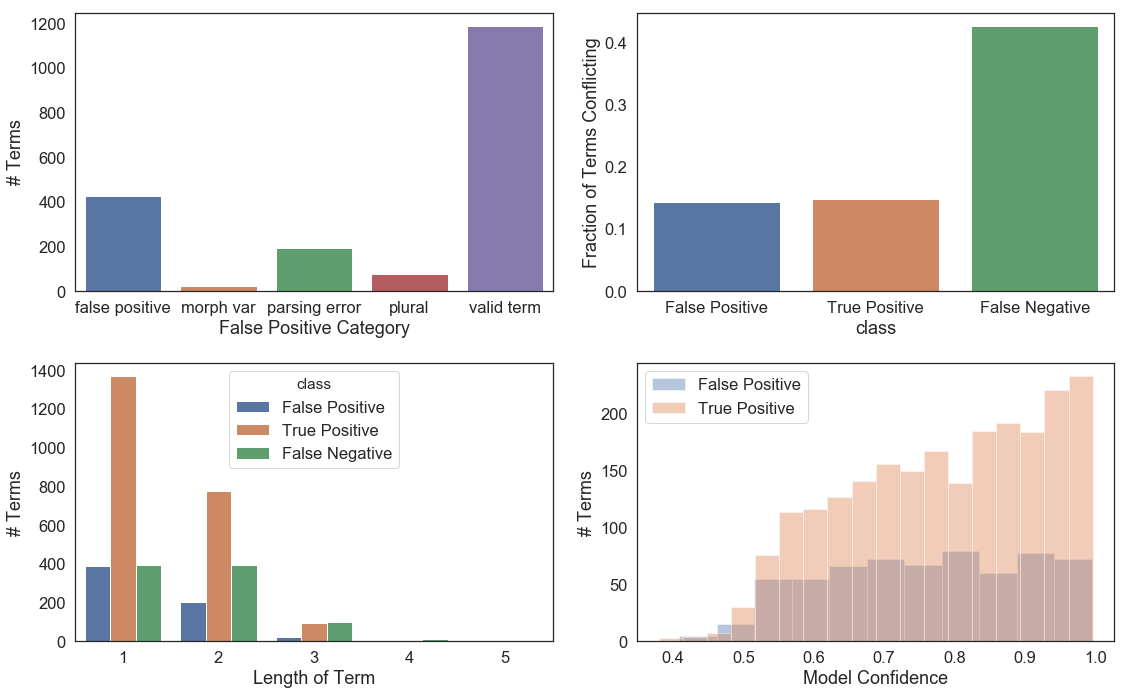

In [230]:
sns.set(style='white', font_scale=1.5)
f, axs = plt.subplots(2, 2, figsize=(16, 10))

# plot false positive breakdown
sns.countplot(data=fp_ann, x='category', ax=axs[0, 0])
axs[0, 0].set_xlabel('False Positive Category')
axs[0, 0].set_ylabel('# Terms')

# plot training conflict
corrected_output['train_conflict'] = (corrected_output['train_count'] > 0).astype(int) * (1 - corrected_output['train_kt'])
sns.barplot(x='class', y='train_conflict', data=corrected_output, ax=axs[0, 1], ci=None)
axs[0, 1].set_ylabel('Fraction of Terms Conflicting')

# split by term count
sns.countplot(x='term_length', hue='class', data=corrected_output, ax=axs[1, 0]);
axs[1, 0].set_xlabel('Length of Term')
axs[1, 0].set_ylabel('# Terms')

# model confidence scores
sns.distplot(corrected_output[corrected_output['class'] == 'False Positive'].prob, ax=axs[1, 1], kde=False, norm_hist=False)
sns.distplot(corrected_output[corrected_output['class'] == 'True Positive'].prob, ax=axs[1, 1], kde=False, norm_hist=False)
axs[1, 1].legend(['False Positive', 'True Positive'])
axs[1, 1].set_ylabel('# Terms')
axs[1, 1].set_xlabel('Model Confidence')

plt.tight_layout()
plt.savefig('error_analysis.png')
plt.show()

# Re-compute Updated Metrics w/ Vinay's Tagging

In [231]:
fp = corrected_output[corrected_output['class'] == 'False Positive'].shape[0]
tp = corrected_output[corrected_output['class'] == 'True Positive'].shape[0]
fn = corrected_output[corrected_output['class'] == 'False Negative'].shape[0]

recall = float(tp) / (tp + fn)
precision = float(tp) / (tp + fp)
f1 = 2 * precision * recall / (precision + recall)
print('# FP: %d, # TP: %d, # FN: %d' % (fp, tp, fn))
print('Corrected Recall: %.3f, Precision: %.3f, F1: %.3f' % (recall, precision, f1))

# FP: 624, # TP: 2245, # FN: 896
Corrected Recall: 0.715, Precision: 0.783, F1: 0.747


# Compute Biologist Output

In [234]:
fp_ann = pd.read_excel('false_pos_test_screenedA.xlsx')

fp_ann.notes = fp_ann.notes.fillna('').astype(str)
fp_ann.loc[fp_ann.notes.str.lower().str.contains('pars'), 'category'] = 'parsing problem'
fp_ann.loc[fp_ann.notes.str.lower().str.contains('incomplete'), 'category'] = 'parsing problem'
fp_ann.loc[fp_ann.notes.str.lower().str.contains('plural'), 'category'] = 'plural'
fp_ann.loc[(fp_ann.category.isnull()) & (fp_ann['true fp'].str.strip() == 'N'), 'category'] = 'valid term'
fp_ann.loc[(fp_ann.category.isnull()) & (fp_ann['true fp'].str.strip() != 'N'), 'category'] = 'false positive'
fp_ann.category = fp_ann.category.replace({'parsing problem': 'parsing error'})

fp_ann = fp_ann.sort_values(by=['category', 'term'])

false_poss = fp_ann[fp_ann['true fp'] != 'N'].term
screen_errs = fp_ann[(fp_ann['true fp'] != 'Y') & (fp_ann['category'] != 'valid term')].term
valid_terms = fp_ann[(fp_ann['category'] == 'valid term')].term
corrected_output = output_df.copy()
corrected_output.loc[corrected_output.term.str.strip().isin(valid_terms), 'class'] = 'True Positive'
corrected_output.loc[corrected_output.term.str.strip().isin(screen_errs), 'class'] = 'DataSet Error'
corrected_output = corrected_output[corrected_output['class'] != 'DataSet Error']
corrected_output.head()

,term,prob,term_length,test_count,train_count,train_kt,class
0,a band,0.586,2,5,6,0,False Positive
1,a horizon,0.488,2,6,0,0,False Positive
2,a site,0.784,2,12,10,0,False Positive
3,abscission zone,0.774,2,1,0,0,True Positive
4,absorption,0.794,1,51,147,1,True Positive


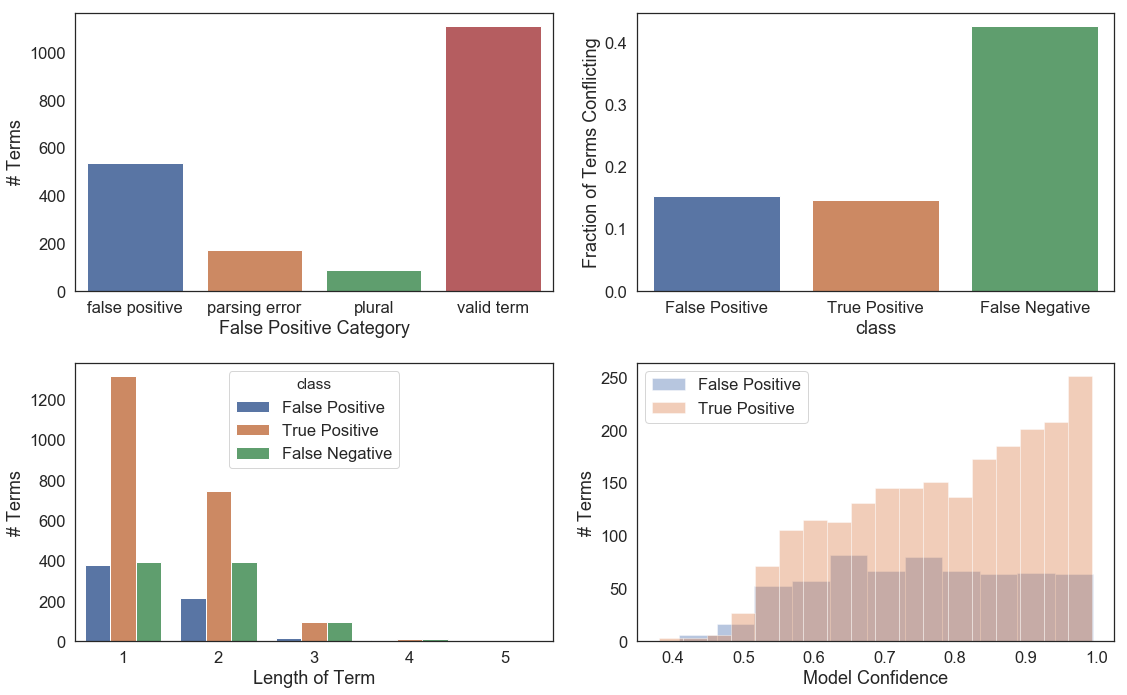

In [238]:
sns.set(style='white', font_scale=1.5)
f, axs = plt.subplots(2, 2, figsize=(16, 10))

# plot false positive breakdown
sns.countplot(data=fp_ann, x='category', ax=axs[0, 0])
axs[0, 0].set_xlabel('False Positive Category')
axs[0, 0].set_ylabel('# Terms')

# plot training conflict
corrected_output['train_conflict'] = (corrected_output['train_count'] > 0).astype(int) * (1 - corrected_output['train_kt'])
sns.barplot(x='class', y='train_conflict', data=corrected_output, ax=axs[0, 1], ci=None)
axs[0, 1].set_ylabel('Fraction of Terms Conflicting')

# split by term count
sns.countplot(x='term_length', hue='class', data=corrected_output, ax=axs[1, 0]);
axs[1, 0].set_xlabel('Length of Term')
axs[1, 0].set_ylabel('# Terms')

# model confidence scores
sns.distplot(corrected_output[corrected_output['class'] == 'False Positive'].prob, ax=axs[1, 1], kde=False, norm_hist=False)
sns.distplot(corrected_output[corrected_output['class'] == 'True Positive'].prob, ax=axs[1, 1], kde=False, norm_hist=False)
axs[1, 1].legend(['False Positive', 'True Positive'])
axs[1, 1].set_ylabel('# Terms')
axs[1, 1].set_xlabel('Model Confidence')

plt.tight_layout()
plt.savefig('error_analysis.png')
plt.show()

In [236]:
fp = corrected_output[corrected_output['class'] == 'False Positive'].shape[0]
tp = corrected_output[corrected_output['class'] == 'True Positive'].shape[0]
fn = corrected_output[corrected_output['class'] == 'False Negative'].shape[0]

recall = float(tp) / (tp + fn)
precision = float(tp) / (tp + fp)
f1 = 2 * precision * recall / (precision + recall)
print('# FP: %d, # TP: %d, # FN: %d' % (fp, tp, fn))
print('Corrected Recall: %.3f, Precision: %.3f, F1: %.3f' % (recall, precision, f1))

# FP: 620, # TP: 2170, # FN: 896
Corrected Recall: 0.708, Precision: 0.778, F1: 0.741
